# RNN Exercises - Solutions
For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1939 to January 2021 (925 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N

In the exercises below you'll be asked to do the following:
* Perform standard imports, load & plot the dataset (code provided)
* Prepare data for an LSTM model
* Define the LSTM model, loss and optimization functions
* Train the model
* Evaluate the model on test data
* OPTIONAL: Plot the results



## Perform standard imports, load and plot the dataset
Run the cells below to load the libraries needed for this exercise and the Energy Production dataset, and to plot the data.

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
## Get Id of default device
torch.cuda.current_device()

0

In [3]:
# 0
torch.cuda.get_device_name(0) # Get name device with ID '0'

'Tesla K80'

In [6]:
# Returns the current GPU memory usage by 
# tensors in bytes for a given device
torch.cuda.memory_allocated()

0

In [7]:
# Returns the current GPU memory managed by the
# caching allocator in bytes for a given device
torch.cuda.memory_reserved()

0

In [8]:
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

path = "https://raw.githubusercontent.com/GeoTurkey/GMT_COURSES/main/IPG2211A2N.csv"

df = pd.read_csv(path,index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

995


,IPG2211A2N
DATE,
1939-01-01,3.3298
1939-02-01,3.3552
1939-03-01,3.4315
1939-04-01,3.4569
1939-05-01,3.4569


In [9]:
df.tail()

,IPG2211A2N
DATE,
2021-07-01,111.6435
2021-08-01,113.4758
2021-09-01,99.7021
2021-10-01,94.2822
2021-11-01,98.2738


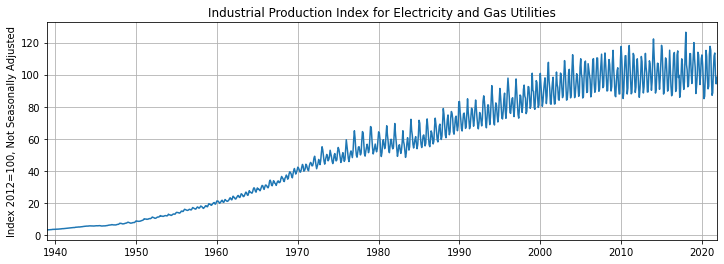

In [10]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

# Prepare the data
For the first set of exercises we'll
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

## 1. Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [11]:
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 24

train_set = y[:-test_size]
test_set = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 983
Test:  12


## 2. Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 3.3298
First item, scaled: [-1.]


## 3. Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [13]:
train_norm = torch.FloatTensor(train_norm).view(-1).cuda()

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [14]:
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 959


## 4. Define the model
Design a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

In [15]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1, hidden_size=120, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size).cuda(),
                       torch.zeros(1,1,self.hidden_size).cuda())

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]
    
torch.manual_seed(101)
model = LSTMnetwork().cuda()
model

LSTMnetwork(
  (lstm): LSTM(1, 120)
  (linear): Linear(in_features=120, out_features=1, bias=True)
)

In [16]:
next(model.parameters()).is_cuda

True

## 5. Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 6. Train the model
Don't worry about tracking loss values, displaying results, or validating the test set. Just train the model through 50 epochs. We'll evaluate the trained model in the next step.<br>
OPTIONAL: print something after each epoch to indicate training progress.

In [18]:
epochs = 200
import time
hist = np.zeros(epochs)
start_time = time.time()

for i in range(epochs):
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size).cuda(),
                        torch.zeros(1,1,model.hidden_size).cuda())
        
        # apply the model
        y_pred = model(seq)
        # update parameters
        loss = criterion(y_pred, y_train)
        hist[i] = loss.item()
        loss.backward()
        optimizer.step()

    # print training result
    if i % 10 == 0 and i !=0:
      print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch: 11 Loss: 0.00061708
Epoch: 21 Loss: 0.00174419
Epoch: 31 Loss: 0.00065193
Epoch: 41 Loss: 0.00002356
Epoch: 51 Loss: 0.00025622
Epoch: 61 Loss: 0.00074504
Epoch: 71 Loss: 0.00006246
Epoch: 81 Loss: 0.00000913
Epoch: 91 Loss: 0.00121947
Epoch: 101 Loss: 0.00115041
Epoch: 111 Loss: 0.00192512
Epoch: 121 Loss: 0.00287803
Epoch: 131 Loss: 0.00013921
Epoch: 141 Loss: 0.00705984
Epoch: 151 Loss: 0.00329647
Epoch: 161 Loss: 0.00625169
Epoch: 171 Loss: 0.00056369
Epoch: 181 Loss: 0.00185739
Epoch: 191 Loss: 0.00051968

Duration: 690 seconds


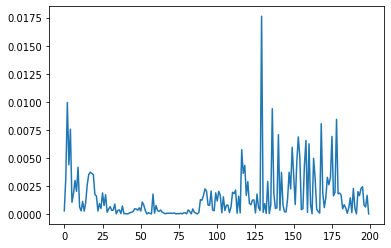

In [19]:
plt.plot(hist)


### 9. Evaluate the model using the test set
Be sure to re-initialize the hidden parameters $h_0$ and $c_0$ before running the model.

In [20]:
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:]).cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).cuda(),
                        torch.zeros(1,1,model.hidden_size).cuda())
        preds.append(model(seq).item())
        
preds[window_size:]

[0.6848156452178955,
 0.873499870300293,
 0.7018704414367676,
 0.5711796879768372,
 0.4124569296836853,
 0.45429661870002747,
 0.6512869596481323,
 0.8362822532653809,
 0.7638360261917114,
 0.6462044715881348,
 0.5185161828994751,
 0.5936781764030457]

## 10. Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [21]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[107.00922701],
       [118.62039194],
       [108.05873738],
       [100.01634861],
       [ 90.24893893],
       [ 92.82365089],
       [104.94595384],
       [116.33011097],
       [111.87194765],
       [104.63318998],
       [ 96.77556553],
       [101.40085046]])

## Plot the result
Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

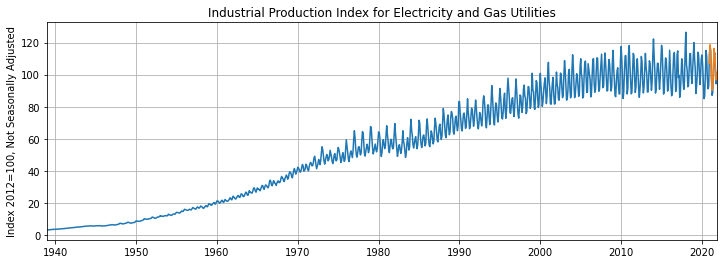

In [22]:
x = np.arange('2020-12-01', '2021-12-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

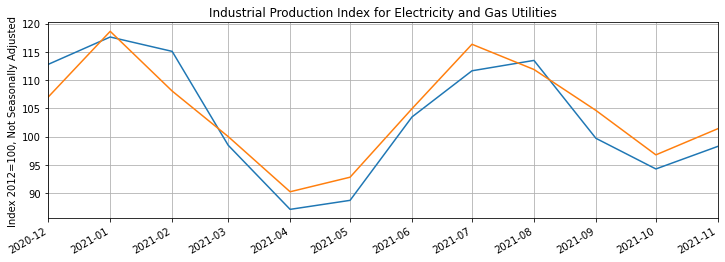

In [23]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2020-12-01':])
plt.plot(x,true_predictions)
plt.show()

In [24]:
# calculate root mean squared error of the training result based on last iteration (epoch) and non-scaled values.
import math
from sklearn.metrics import mean_squared_error

testScore = math.sqrt(mean_squared_error(test_set.reshape(-1,1), true_predictions.reshape(-1,1)))
print('Test Score: %.4f RMSE' % (testScore))

Test Score: 3.8654 RMSE
